In [3]:
import math
import random
import numpy as np

# Constants
PI = math.pi
LIGHTSPEED = 2.997925E10  # Speed of light in vacuum [cm/s]
ALIVE = 1                 # Photon is alive
DEAD = 0                  # Photon is dead
THRESHOLD = 0.01          # Threshold weight for Roulette
CHANCE = 0.1              # Chance of survival in Roulette
COS90D = 1.0E-6           # Cosine of angle close to 90 degrees
ONE_MINUS_COSZERO = 1.0E-12  # 1 minus cosine of angle close to 0 degrees

def SIGN(x):
    """Return the sign of x."""
    return 1 if x >= 0 else -1

def InitRandomGen(seed):
    """Initialize the random number generator with a specific seed."""
    random.seed(seed)

In [4]:
def HOP(x, y, z, ux, uy, uz, mua, mus):
    """
    Perform the HOP step: move the photon to a new position.

    Parameters:
        x, y, z (float): Current photon position coordinates.
        ux, uy, uz (float): Current photon trajectory cosines.
        mua (float): Absorption coefficient [cm^-1].
        mus (float): Scattering coefficient [cm^-1].

    Returns:
        x, y, z (float): Updated photon position coordinates.
        s (float): Step size taken [cm].
    """
    # Generate a random number (0,1) and calculate step size
    rnd = random.random() 
    while rnd <= 0.0:
        rnd = random.random()
    s = -math.log(rnd) / (mua + mus)  # Step size [cm]

    # Update photon position
    x += s * ux
    y += s * uy
    z += s * uz

    return x, y, z, s

In [5]:
def DROP(x, y, z, W, albedo, dr, NR, Csph, Ccyl, Cpla):
    """
    Perform the DROP step: update photon weight and accumulate absorbed weight.

    Parameters:
        x, y, z (float): Current photon position coordinates.
        W (float): Current photon weight.
        albedo (float): Albedo (scattering probability).
        dr (float): Radial bin size [cm].
        NR (int): Number of radial bins.
        Csph, Ccyl, Cpla (list): Arrays to accumulate absorbed weights.

    Returns:
        W (float): Updated photon weight after absorption.
    """
    # Calculate absorbed weight and update photon weight
    absorb = W * (1.0 - albedo)  # Absorbed weight during this step
    W -= absorb                  # Decrease photon weight by absorbed amount

    # Accumulate absorbed weight in spatial bins

    # Spherical coordinates
    r = math.sqrt(x * x + y * y + z * z)  # Radial distance from origin [cm]
    ir = int(r / dr)                      # Determine radial bin index
    if ir >= NR:
        ir = NR                           # Assign to overflow bin if outside range
    Csph[ir] += absorb                    # Add absorbed weight to spherical bin

    # Cylindrical coordinates
    r_cyl = math.sqrt(x * x + y * y)      # Radial distance in xy-plane [cm]
    ir = int(r_cyl / dr)                  # Determine radial bin index
    if ir >= NR:
        ir = NR                           # Assign to overflow bin if outside range
    Ccyl[ir] += absorb                    # Add absorbed weight to cylindrical bin

    # Planar coordinates
    r_pla = abs(z)                        # Absolute z-position [cm]
    ir = int(r_pla / dr)                  # Determine radial bin index
    if ir >= NR:
        ir = NR                           # Assign to overflow bin if outside range
    Cpla[ir] += absorb                    # Add absorbed weight to planar bin

    return W,Csph, Ccyl, Cpla

In [6]:
def SPIN(ux, uy, uz, g):
    """
    Perform the SPIN step: scatter photon into a new direction.

    Parameters:
        ux, uy, uz (float): Current photon trajectory cosines.
        g (float): Anisotropy factor.

    Returns:
        ux, uy, uz (float): Updated photon trajectory cosines.
    """
    # Sample scattering angle theta using Henyey-Greenstein phase function
    rnd = random.random()
    if g == 0.0:
        costheta = 2.0 * rnd - 1.0
    else:
        temp = (1.0 - g * g) / (1.0 - g + 2 * g * rnd)
        costheta = (1.0 + g * g - temp * temp) / (2.0 * g)
    sintheta = math.sqrt(1.0 - costheta * costheta)  # Sine of theta

    # Sample azimuthal angle psi uniformly from [0, 2PI]
    psi = 2.0 * PI * random.random()
    cospsi = math.cos(psi)
    sinpsi = math.sin(psi)

    # Update photon trajectory based on new angles
    if 1 - abs(uz) <= ONE_MINUS_COSZERO:
        # Near perpendicular incidence
        uxx = sintheta * cospsi
        uyy = sintheta * sinpsi
        uzz = costheta * SIGN(uz)
    else:
        # General case
        temp = math.sqrt(1.0 - uz * uz)
        uxx = sintheta * (ux * uz * cospsi - uy * sinpsi) / temp + ux * costheta
        uyy = sintheta * (uy * uz * cospsi + ux * sinpsi) / temp + uy * costheta
        uzz = -sintheta * cospsi * temp + uz * costheta

    # Normalize the direction cosines to prevent accumulation of errors
    norm = math.sqrt(uxx * uxx + uyy * uyy + uzz * uzz)
    ux = uxx / norm
    uy = uyy / norm
    uz = uzz / norm

    return ux, uy, uz

In [7]:
# Optical properties
mua = 0.1            # Absorption coefficient [cm^-1]
mus = 10          # Scattering coefficient [cm^-1]
g = 0.90             # Anisotropy factor [-]
nt = 1.33            # Tissue refractive index

# Simulation parameters
Nphotons = 10000     # Number of photons in simulation
radial_size = 3.0    # Maximum radial size [cm]
NR = 100             # Number of radial bins
dr = radial_size / NR  # Radial bin size [cm]
albedo = mus / (mus + mua) if (mus + mua) != 0 else 0  # Albedo (scattering probability)

# Initialize random number generator
random.seed(1)  # Seed the random number generator with seed 1

# Initialize arrays to store photon concentrations
Csph = [0.0] * (NR + 1)   # Spherical photon concentration
Ccyl = [0.0] * (NR + 1)   # Cylindrical photon concentration
Cpla = [0.0] * (NR + 1)   # Planar photon concentration

In [8]:
for i_photon in range(int(Nphotons)):
    # LAUNCH and initialize photon position and trajectory for an isotropic point source
    W = 1.0                # Set initial photon weight to 1
    photon_status = ALIVE  # Photon is alive

    # Set initial position at the origin
    x = y = z = 0.0

    # Randomly set photon trajectory for isotropic emission
    costheta = 2.0 *  random.random() - 1.0  # Cosine of polar angle theta between [-1, 1]
    sintheta = math.sqrt(1.0 - costheta **2)  # Sine of theta (always positive) [0, 1]
    psi = 2.0 * PI *  random.random()       # Azimuthal angle psi [0, 2PI]

    # Convert spherical coordinates to Cartesian coordinates for trajectory
    ux = sintheta * math.cos(psi)
    uy = sintheta * math.sin(psi)
    uz = costheta

    # HOP_DROP_SPIN_CHECK
    # Propagate the photon until it dies
    while photon_status == ALIVE:
        # HOP
        x, y, z, s = HOP(x, y, z, ux, uy, uz, mua, mus)

        # DROP
        W, Csph, Ccyl, Cpla = DROP(x, y, z, W, albedo, dr, NR, Csph, Ccyl, Cpla)

        # SPIN
        ux, uy, uz = SPIN(ux, uy, uz, g)

        # CHECK ROULETTE
        # Apply Roulette technique if photon weight is below threshold
        if W < THRESHOLD:
            if  random.random() <= CHANCE:
                W /= CHANCE  # Survives with increased weight
            else:
                photon_status = DEAD  # Photon is terminated


In [10]:
# Compute radial positions
ir = np.arange(NR + 1)
r = (ir + 0.5) * dr

# Compute shell volumes
shellvolume_sph = 4.0 * PI * r**2 * dr
shellvolume_cyl = 2.0 * PI * r * dr
shellvolume_pla = dr  # Constant for all bins

# Avoid division by zero for r = 0 in cylindrical and spherical volumes
shellvolume_sph[0] = (4.0 / 3.0) * PI * ( ( (ir[0] + 1) * dr )**3 - (ir[0] * dr )**3 )
shellvolume_cyl[0] = PI * dr**2

# Convert lists to numpy arrays
Csph = np.array(Csph)
Ccyl = np.array(Ccyl)
Cpla = np.array(Cpla)

# Compute fluence rates as vectors
Fsph = Csph / (Nphotons * mua * shellvolume_sph)
Fcyl = Ccyl / (Nphotons * mua * shellvolume_cyl)
Fpla = Cpla / (Nphotons * mua * shellvolume_pla)

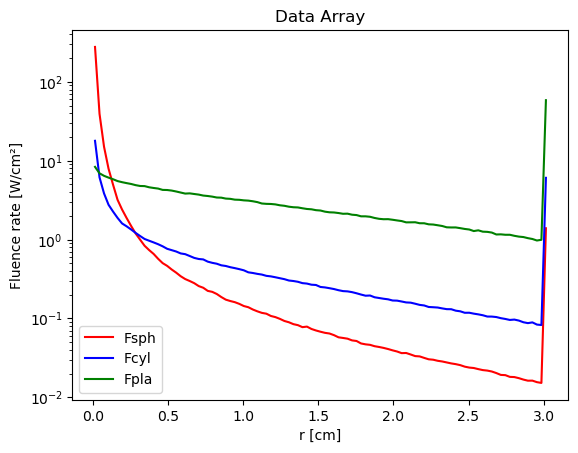

In [12]:
import matplotlib.pyplot as plt

plt.plot(r, Fsph, '-', label='Fsph', color='red')
plt.plot(r, Fcyl, '-', label='Fcyl', color='blue')
plt.plot(r, Fpla, '-', label='Fpla', color='green')
plt.yscale('log')
plt.xlabel('r [cm]')
plt.ylabel('Fluence rate [W/cm²]')
plt.legend()
plt.title('Data Array')
plt.show()